In [ ]:
#If you are working in a notebook or ipython environment, you may need to uncomment the line below to install the oceanum python library
#!pip install oceanum

### Import required modules


In [3]:
from oceanum.datamesh import Connector
datamesh = Connector(token='your_token', service='https://datamesh-v0.oceanum.io')  # Replace with your token

Using datamesh API version 0
You are using version 1.0.13 of oceanum_python which is the latest version available.


### Build the query


In [4]:
query={
    "datasource":"antair_ice_2003_2021",
    "variables":["band_data"],
    "timefilter":{"type":"range",
        "times":["2020-07-29T00:00:00+00:00","2020-07-29T00:00:00+00:00"],
        "resolution":"native",
        "resample":"linear"},
    "id":"74e81a14368259125959b48fd00883d2"}

### Send the query to Datamesh

In [5]:
ds = datamesh.query(query)
print(ds)

<xarray.Dataset> Size: 935MB
Dimensions:    (time: 1, band: 2, y: 7193, x: 8127)
Coordinates:
  * band       (band) int32 8B 1 2
  * time       (time) datetime64[ns] 8B 2020-07-29
  * x          (x) float64 65kB -3.503e+06 -3.502e+06 ... 4.622e+06 4.623e+06
  * y          (y) float64 58kB 3.596e+06 3.595e+06 ... -3.595e+06 -3.596e+06
Data variables:
    band_data  (time, band, y, x) float64 935MB nan nan nan nan ... nan nan nan
Attributes:
    _coordinates:   {"i":"band","t":"time","x":"x","y":"y"}
    _request_size:  935442752


### Plot the data


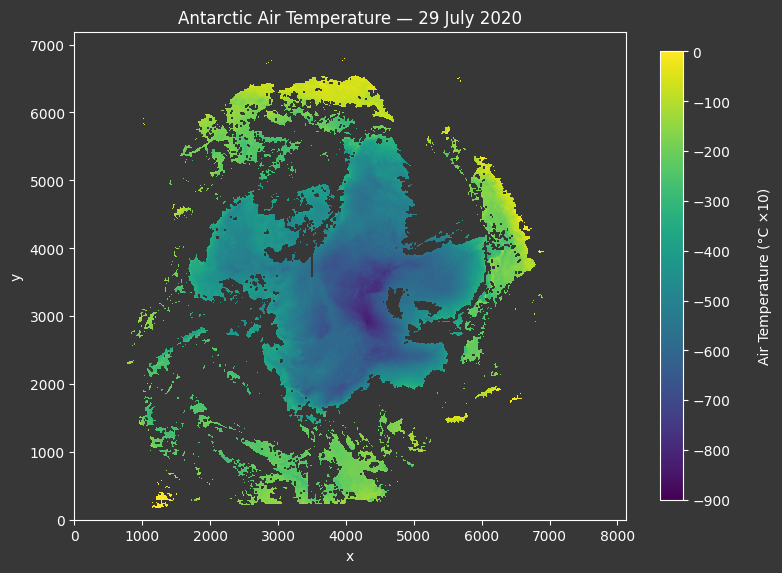

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors

# dark grey background rgb(55,55,56)
bg = (55/255, 55/255, 56/255)

# Subset the data - selecting the first band (temperature) and first time step (the only step in our data but still necessary)
da = ds.band_data.isel(time=0, band=0)

# Order the colors
norm = colors.Normalize(vmin=-900, vmax=-0)

fig, ax = plt.subplots(figsize=(8, 6), facecolor=bg)
ax.set_facecolor(bg)

im = ax.imshow(
    da,
    origin="lower",
    cmap="viridis",
    norm=norm,
    aspect="equal",
)

# Formatting
cbar = fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.85)
cbar.ax.set_facecolor(bg)
cbar.outline.set_edgecolor("white")
cbar.set_label("Air Temperature (°C ×10)", color="white", rotation=90, labelpad=20)
cbar.ax.yaxis.set_tick_params(color="white")
plt.setp(cbar.ax.get_yticklabels(), color="white")

# Axes formatting
ax.set_title("Antarctic Air Temperature — 29 July 2020", color="white")
ax.set_xlabel("x", color="white")
ax.set_ylabel("y", color="white")
ax.tick_params(colors="white", which="both")

# Make spines white
for spine in ax.spines.values():
    spine.set_edgecolor("white")

plt.tight_layout()
plt.show()

### Clip the data to Antarctica - get a polygon to clip with

In [10]:
query_coastline={
    "datasource":"high_res_vector_polygons_antarctic_coastline",
    "variables":["geometry"],
    "id":"74e81a14368259125959b48fd00883d2"}

coastline=datamesh.query(query_coastline)

### Clip to Antarctica

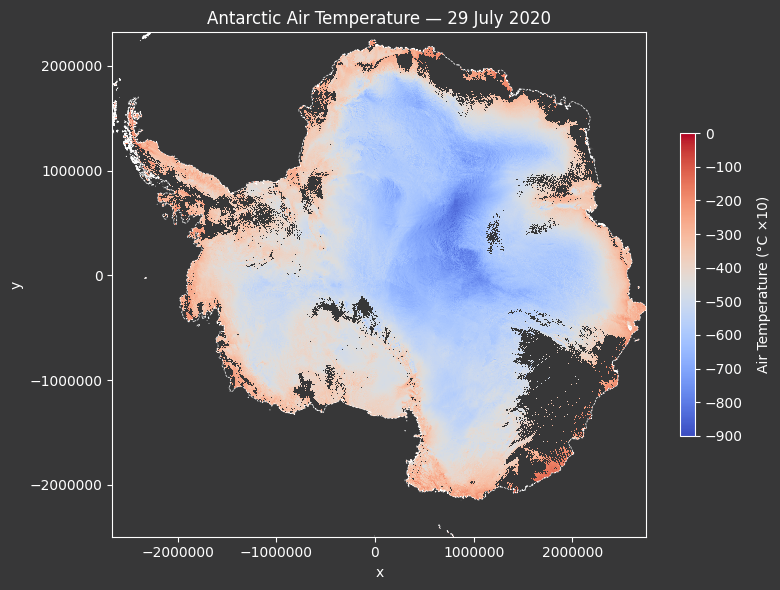

In [11]:
import xarray as xr
import rioxarray  # enables .rio accessor
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from shapely.ops import unary_union

# Write CRS to the data
ds = ds.rio.write_crs("EPSG:3031")

# --- Project coastline and union ---
coastline_proj = coastline.to_crs(ds.rio.crs)
coastline_union = unary_union(coastline_proj.geometry)

# --- Clip to inside coastline ---
ds_temp_clipped = ds.rio.clip([coastline_union], coastline_proj.crs, drop=True, invert=False)

# --- Pick slice ---
ds_temp = ds_temp_clipped["band_data"].isel(time=0, band=0)  # 2D

# --- Coordinate grids ---
x = ds_temp_clipped["x"].values
y = ds_temp_clipped["y"].values
x2d, y2d = np.meshgrid(x, y)

# --- Normalize (vmin < vmax) ---
norm = colors.Normalize(vmin=-900, vmax=0)

# --- Plot ---
bg = (55 / 255, 55 / 255, 56 / 255)  # dark grey background
fig, ax = plt.subplots(figsize=(8, 6), facecolor=bg)
ax.set_facecolor(bg)

# pcolormesh of clipped data with normalization
mesh = ax.pcolormesh(
    x2d,
    y2d,
    ds_temp.values.squeeze(),
    cmap="coolwarm",
    norm=norm,
    shading="auto",
)

# # overlay high-resolution coastline (handles MultiPolygon)
def plot_shapely(ax, geom, **kwargs):
    if geom.is_empty:
        return
    if geom.geom_type == "Polygon":
        x_ex, y_ex = geom.exterior.xy
        ax.plot(x_ex, y_ex, **kwargs)
        for interior in geom.interiors:
            xi, yi = interior.xy
            ax.plot(xi, yi, **kwargs)
    elif geom.geom_type == "MultiPolygon":
        for part in geom.geoms:
            plot_shapely(ax, part, **kwargs)


plot_shapely(ax, coastline_union, color="white", linestyle="--", linewidth=0.5)


# axis formatting
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title("Antarctic Air Temperature — 29 July 2020", color="white")
ax.set_xlabel("x", color="white")
ax.set_ylabel("y", color="white")
ax.tick_params(colors="white", which="both")
ax.ticklabel_format(style="plain", axis="both", useOffset=False)
for spine in ax.spines.values():
    spine.set_edgecolor("white")


# colorbar with updated label
cbar = fig.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.6)

cbar.set_label("Air Temperature (°C ×10)", color="white", labelpad=10)
plt.setp(cbar.ax.get_yticklabels(), color="white")
cbar.ax.yaxis.set_tick_params(color="white")
cbar.outline.set_edgecolor("white")
cbar.ax.set_facecolor(bg)

plt.tight_layout()
plt.show()

### Overlay ERA5 Wind data - call data from ERA5

In [13]:
from oceanum.datamesh import Connector

datamesh=Connector(token='your_token', service='https://datamesh-v0.oceanum.io') # Connect to the Datamesh

# Construct the query
query_era5= {
  "datasource": "era5_wind100m",
  "geofilter": {
    "type": "bbox",
    "geom": [0,-90,360,-60],
    "interp": "linear"
  },
  "timefilter":{"type":"range","times":["2020-07-29T00:00:00+00:00","2020-07-29T00:00:00+00:00"]}
}

era5_wind = datamesh.query(query_era5) # Call the data

print(era5_wind) # Show the data

Using datamesh API version 0
You are using version 1.0.13 of oceanum_python which is the latest version available.
<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 121, longitude: 1440, time: 1)
Coordinates:
  * latitude   (latitude) float32 484B -60.0 -60.25 -60.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 8B 2020-07-29
Data variables:
    u100       (time, latitude, longitude) float32 697kB 2.085 2.983 ... 0.6002
    v100       (time, latitude, longitude) float32 697kB -11.86 ... 0.1969
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    cycle:                   2025-04-01T00:00:00
    history:                 2025-05-18T19:18 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts
   

### Plot AntAir ICE and ERA5 data - compute variables 

In [15]:
import xarray as xr
import rioxarray  # enables .rio accessor
from rasterio.enums import Resampling

# --- reproject u100 ---
u100_3031 = (
    era5_wind["u100"]
    .rename({"longitude": "x", "latitude": "y"})
    .rio.set_spatial_dims(x_dim="x", y_dim="y")
    .rio.write_crs("EPSG:4326")
    .rio.reproject("EPSG:3031", resampling=Resampling.bilinear)
    .rename("u100")
)

# --- reproject v100 ---
v100_3031 = (
    era5_wind["v100"]
    .rename({"longitude": "x", "latitude": "y"})
    .rio.set_spatial_dims(x_dim="x", y_dim="y")
    .rio.write_crs("EPSG:4326")
    .rio.reproject("EPSG:3031", resampling=Resampling.bilinear)
    .rename("v100")
)

# --- compute wind magnitude ---
wind = ((u100_3031 ** 2 + v100_3031 ** 2) ** 0.5).rename("wind")

# --- assemble into single Dataset ---
ds_wind_3031 = xr.Dataset(
    {
        "u100": u100_3031,
        "v100": v100_3031,
        "wind": wind,
    },
    attrs=era5_wind.attrs.copy(),
)

# --- preserve/augment variable attributes ---
for var in ("u100", "v100"):
    ds_wind_3031[var].attrs.update(era5_wind[var].attrs)
ds_wind_3031["wind"].attrs["long_name"] = "wind speed magnitude"
# optionally set units if u100/v100 share same units (e.g., m s-1)
ds_wind_3031["wind"].attrs["units"] = era5_wind["u100"].attrs.get("units", "")

### Plot AntAir ICE and ERA5 data

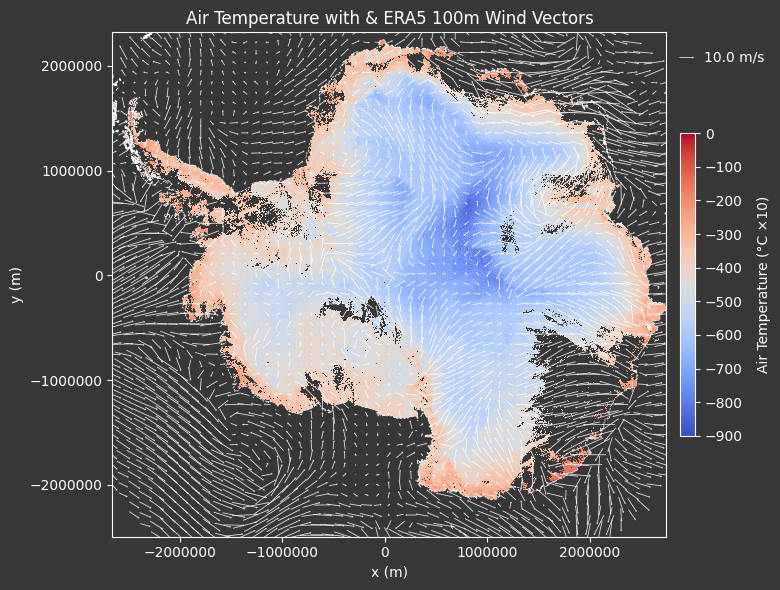

In [19]:
# --- wind: select time slice then reproject-match to temp grid -----------------------
time_sel = 0  # same time index you want to overlay
u_sel = ds_wind_3031["u100"].isel(time=time_sel)
v_sel = ds_wind_3031["v100"].isel(time=time_sel)

# align u/v to the temperature grid so they share x/y
u_matched = u_sel.rio.reproject_match(ds_temp)
v_matched = v_sel.rio.reproject_match(ds_temp)

# compute wind speed magnitude
wind = ((u_matched ** 2 + v_matched ** 2) ** 0.5).rename("wind")

# --- coordinate grids ---------------------------------------------------------------
x = ds_temp["x"].values
y = ds_temp["y"].values
x2d, y2d = np.meshgrid(x, y)

# --- arrow density ------------------------------------------------------------------
desired_n = 50
step_x = max(1, len(x) // desired_n)
step_y = max(1, len(y) // desired_n)

# --- arrow scaling: make reference arrow (e.g., 10 m/s) a fixed fraction of domain ----
ref_speed = 10.0  # m/s
arrow_frac = 0.03  # smaller fraction than before so arrows are shorter (was 0.05)
dx = x.max() - x.min()
dy = y.max() - y.min()
domain_min = min(dx, dy)
target_ref_arrow_len = arrow_frac * domain_min  # display length for ref_speed
length_scale = target_ref_arrow_len / ref_speed

u_scaled = u_matched.values * length_scale
v_scaled = v_matched.values * length_scale

# --- plotting -----------------------------------------------------------------------
bg = (55 / 255, 55 / 255, 56 / 255)
fig, ax = plt.subplots(figsize=(8, 6), facecolor=bg)
ax.set_facecolor(bg)

# temperature background
norm = colors.Normalize(vmin=-900, vmax=0)
pcm = ax.pcolormesh(
    x2d,
    y2d,
    ds_temp.values.squeeze(),
    cmap="coolwarm",
    norm=norm,
    shading="auto",
)

# temperature colorbar
cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.6, pad=0.02)
cbar.set_label("Air Temperature (°C ×10)", color="white", labelpad=10)
plt.setp(cbar.ax.get_yticklabels(), color="white")
cbar.ax.yaxis.set_tick_params(color="white")
cbar.outline.set_edgecolor("white")
cbar.ax.set_facecolor(bg)

# wind vectors (direction + length)
Q = ax.quiver(
    x2d[::step_y, ::step_x],
    y2d[::step_y, ::step_x],
    u_scaled[::step_y, ::step_x],
    v_scaled[::step_y, ::step_x],
    angles="xy",
    scale_units="xy",
    scale=1,
    width=0.0015,         
    headwidth=2.5,         
    headlength=2,
    headaxislength=2,
    pivot="middle",
    color="white",
    alpha=0.85,
)

# reference arrow for 10 m/s
ax.quiverkey(
    Q,
    1.05,
    0.95,
    ref_speed * length_scale,
    f"{ref_speed} m/s",
    labelcolor="white",
    coordinates="axes",
    labelpos="E"
)

plot_shapely(ax, coastline_union, color="white", linestyle="--", linewidth=0.5)

# formatting
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title("Air Temperature with & ERA5 100m Wind Vectors", color="white")
ax.set_xlabel("x (m)", color="white")
ax.set_ylabel("y (m)", color="white")
ax.tick_params(colors="white", which="both")
ax.ticklabel_format(style="plain", axis="both", useOffset=False)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

plt.tight_layout()
plt.show()
